# A more advanced introduction to scikit-learn

We will draw couple of plots during the tutorial. We activate matplotlib to show the plots inline in the notebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

## Why this tutorial?

`scikit-learn` provides state-of-the-art machine learning algorithms. 
These algorithms, however, cannot be directly used on raw data. Raw data needs to be preprocessed beforehand. Thus, besides machine learning algorithms, `scikit-learn` provides a set of preprocessing methods. Furthermore, `scikit-learn` provides connectors for pipelining these estimators (i.e., transformer, regressor, classifier, clusterer, etc.).

In this tutorial, we will present the set of `scikit-learn` functionalities allowing for pipelining estimators, evaluating those pipelines, tuning those pipelines using hyper-parameters optimization, and creating complex preprocessing steps.

## 1. Basic use-case: train and test a classifier

For this first example, we will train and test a classifier on a dataset. We will use this example to recall the API of `scikit-learn`.

We will use the `digits` dataset which is a dataset of hand-written digits.

In [2]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)

Each row in `X` contains the intensities of the 64 image pixels. For each sample in `X`, we get the ground-truth `y` indicating the digit written.

The digit in the image is 0


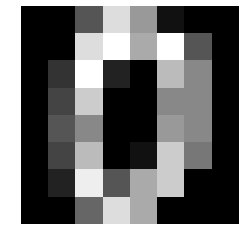

In [3]:
plt.imshow(X[0].reshape(8, 8), cmap='gray');
plt.axis('off')
print('The digit in the image is {}'.format(y[0]))

In machine learning, we should evaluate our model by training and testing it on distinct sets of data. `train_test_split` is a utility function to split the data into two independent sets. The `stratify` parameter enforces the classes distribution of the train and test datasets to be the same than the one of the entire dataset.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Once we have independent training and testing sets, we can learn a machine learning model using the `fit` method. We will use the `score` method to test this method, relying on the default accuracy metric.

In [5]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=5000, random_state=42)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__, accuracy))

Accuracy score of the LogisticRegression is 0.95


The API of `scikit-learn` is consistent across classifiers. Thus, we can easily replace the `LogisticRegression` classifier by a `RandomForestClassifier`. These changes are minimal and only related to the creation of the classifier instance.

In [6]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__, accuracy))

Accuracy score of the RandomForestClassifier is 0.96


#### Exercise

Do the following exercise:

1. load the breast cancer dataset.
2. split the dataset to keep 30% of it into a test set. Make sure to stratify the data and set the `random_state` to `0`.
3. train a supervised classifier on it using the training data.
4. predict the labels of the testing samples.
4. check the `balanced_accuracy_score` on those prediction.

In [7]:
# %load solutions/01_solutions.py

## 2. More advanced use-case: preprocess the data before training and testing a classifier

### 2.1 Standardize your data

Preprocessing might be required before learning a model. For instance, a user could be interested in creating hand-crafted features or an algorithm might make some apriori assumptions about the data. 

In our case, the solver used by the `LogisticRegression` expects the data to be normalized. Thus, we need to standardize the data before training the model. To observe this necessary condition, we will check the number of iterations required to train the model.

In [8]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=5000, random_state=42)
clf.fit(X_train, y_train)
print('{} required {} iterations to be fitted'.format(clf.__class__.__name__, clf.n_iter_[0]))

LogisticRegression required 1493 iterations to be fitted


The `MinMaxScaler` transformer is used to normalise the data. This scaler should be applied in the following way: learn (i.e., `fit` method) the statistics on a training set and standardize (i.e., `transform` method) both the training and testing sets. Finally, we will train and test the model and the scaled datasets.

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000, random_state=42)
clf.fit(X_train_scaled, y_train)
accuracy = clf.score(X_test_scaled, y_test)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__, accuracy))
print('{} required {} iterations to be fitted'.format(clf.__class__.__name__, clf.n_iter_[0]))

Accuracy score of the LogisticRegression is 0.96
LogisticRegression required 187 iterations to be fitted


By scaling the data, the convergence of the model happened much faster than with the unscaled data.

### 2.2 The wrong preprocessing patterns

We highlighted how to preprocess and adequately train a machine learning model. It is also interesting to spot what would be the wrong way of preprocessing data. There are two potential mistakes which are easy to make but easy to spot.

The first pattern is to standardize the data before spliting the full set into training and testing sets.

In [10]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train_prescaled, X_test_prescaled, y_train_prescaled, y_test_prescaled = train_test_split(
    X_scaled, y, stratify=y, random_state=42)

clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000, random_state=42)
clf.fit(X_train_prescaled, y_train_prescaled)
accuracy = clf.score(X_test_prescaled, y_test_prescaled)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__, accuracy))

Accuracy score of the LogisticRegression is 0.96


The second pattern is to standardize the training and testing sets independently. It comes back to call the `fit` methods on both training and testing sets. Thus, the training and testing sets are standardized differently.

In [11]:
scaler = MinMaxScaler()
X_train_prescaled = scaler.fit_transform(X_train)
X_test_prescaled = scaler.fit_transform(X_test)

clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000, random_state=42)
clf.fit(X_train_prescaled, y_train)
accuracy = clf.score(X_test_prescaled, y_test)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__, accuracy))

Accuracy score of the LogisticRegression is 0.96


### 2.3 Keep it simple, stupid: use the pipeline connector from `scikit-learn`

The two previous patterns are an issue with data leaking. However, this is difficult to prevent such a mistake when one has to do the preprocessing by hand. Thus, `scikit-learn` introduced the `Pipeline` object. It sequentially connects several transformers and a classifier (or a regressor). We can create a pipeline as:

In [12]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[('scaler', MinMaxScaler()),
                       ('clf', LogisticRegression(solver='lbfgs', multi_class='auto', random_state=42))])

We see that this pipeline contains the parameters of both the scaler and the classifier. Sometimes, it can be tedious to give a name to each estimator in the pipeline. `make_pipeline` will give a name automatically to each estimator which is the lower case of the class name.

In [13]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(MinMaxScaler(),
                     LogisticRegression(solver='lbfgs', multi_class='auto', random_state=42, max_iter=1000))

The pipeline will have an identical API. We use `fit` to train the classifier and `score` to check the accuracy. However, calling `fit` will call the method `fit_transform` of all transformers in the pipeline. Calling `score` (or `predict` and `predict_proba`) will call internally `transform` of all transformers in the pipeline. It corresponds to the normalization procedure in Sect. 2.1.

In [14]:
pipe.fit(X_train, y_train)
accuracy = pipe.score(X_test, y_test)
print('Accuracy score of the {} is {:.2f}'.format(pipe.__class__.__name__, accuracy))

Accuracy score of the Pipeline is 0.96


We can check all the parameters of the pipeline using `get_params()`.

In [15]:
pipe.get_params()

{'memory': None,
 'steps': [('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
  ('logisticregression',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=1000, multi_class='auto',
             n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
             tol=0.0001, verbose=0, warm_start=False))],
 'minmaxscaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=1000, multi_class='auto',
           n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
           tol=0.0001, verbose=0, warm_start=False),
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__int

#### Exercise

Reuse the breast dataset of the first exercise to train a `SGDClassifier`. Make a pipeline with this classifier and a `StandardScaler`. Train and test this pipeline.

In [16]:
# %load solutions/02_solutions.py

## 3. When more is better than less: cross-validation instead of single split

Splitting the data is necessary to evaluate the statistical model performance. However, it reduces the number of samples which can be used to learn the model. Therefore, one should use cross-validation whenever possible. Having multiple splits will give information about the model stability as well. 

`scikit-learn` provides three functions: `cross_val_score`, `cross_val_predict`, and [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html). The two former functions are a specific case of the latter one. Thus, we will focus on the latter.

In [17]:
from sklearn.model_selection import cross_validate

pipe = make_pipeline(MinMaxScaler(),
                     LogisticRegression(solver='lbfgs', multi_class='auto',
                                        max_iter=1000, random_state=42))
scores = cross_validate(pipe, X, y, cv=3, return_train_score=True)

Using the cross-validate function, we can quickly check the training and testing scores and make a quick plot using `pandas`.

In [18]:
import pandas as pd

df_scores = pd.DataFrame(scores)
df_scores

,fit_time,score_time,test_score,train_score
0,0.314098,0.000806,0.925249,0.988285
1,0.232495,0.001907,0.943239,0.984975
2,0.232513,0.001162,0.924497,0.993339


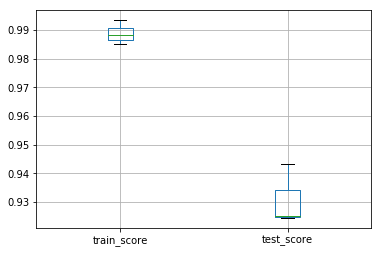

In [19]:
df_scores[['train_score', 'test_score']].boxplot()

#### Exercise

Use the pipeline of the previous exercise and make a cross-validation instead of a single split evaluation.

In [20]:
# %load solutions/03_solutions.py

## 4. Hyper-parameters optimization: fine-tune the inside of a pipeline

Sometimes you would like to find the parameters of a component of the pipeline which lead to the best accuracy. We already saw that we could check the parameters of a pipeline using `get_params()`.

In [21]:
pipe.get_params()

{'memory': None,
 'steps': [('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
  ('logisticregression',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=1000, multi_class='auto',
             n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
             tol=0.0001, verbose=0, warm_start=False))],
 'minmaxscaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=1000, multi_class='auto',
           n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
           tol=0.0001, verbose=0, warm_start=False),
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__int

Hyper-parameters can be optimized by an exhaustive search. [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) provides such utility and does a cross-validated grid-search over a parameter grid.

Let's give an example in which we would like to optimize the `C` and `penalty` parameters of the `LogisticRegression` classifier.

In [22]:
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(MinMaxScaler(),
                     LogisticRegression(solver='saga', multi_class='auto',
                                        random_state=42, max_iter=5000))
param_grid = {'logisticregression__C': [0.1, 1.0, 10],
              'logisticregression__penalty': ['l2', 'l1']}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

Accuracy score of the GridSearchCV is 0.96


When fitting the grid-search object, it finds the best possible parameter combination on the training set (using cross-validation). We can introspect the results of the grid-search by accessing the attribute `cv_results_`. It allows us to check the effect of the parameters on the model performance.

In [25]:
df_grid = pd.DataFrame(grid.cv_results_)
df_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.644352,0.046463,0.029578,0.002757,0.1,l2,"{'logisticregression__C': 0.1, 'logisticregres...",0.951542,0.935268,0.941573,0.942836,0.006717,5,0.952968,0.959956,0.952328,0.955084,0.003455
1,1.213176,0.291430,0.001936,0.000980,0.1,l1,"{'logisticregression__C': 0.1, 'logisticregres...",0.885463,0.908482,0.883146,0.892353,0.011425,6,0.905935,0.902113,0.902439,0.903496,0.001730
2,1.750635,0.102470,0.001499,0.000715,1,l2,"{'logisticregression__C': 1.0, 'logisticregres...",0.977974,0.955357,0.957303,0.963623,0.010263,2,0.985442,0.987764,0.986696,0.986634,0.000949
3,6.060635,1.862678,0.000937,0.000397,1,l1,"{'logisticregression__C': 1.0, 'logisticregres...",0.964758,0.950893,0.943820,0.953229,0.008710,4,0.977604,0.977753,0.981153,0.978837,0.001639
4,5.789593,0.822228,0.001128,0.000334,10,l2,"{'logisticregression__C': 10, 'logisticregress...",0.977974,0.962054,0.964045,0.968077,0.007103,1,1.000000,1.000000,1.000000,1.000000,0.000000
5,21.464093,2.453612,0.001144,0.000178,10,l1,"{'logisticregression__C': 10, 'logisticregress...",0.973568,0.957589,0.950562,0.960653,0.009643,3,1.000000,1.000000,1.000000,1.000000,0.000000


By default, the grid-search object is also behaving as an estimator. Once it is fitted, calling `score` will fix the hyper-parameters to the best parameters found.

In [26]:
grid.best_params_

{'logisticregression__C': 10, 'logisticregression__penalty': 'l2'}

Besides this is possible to call the grid-search as any other classifier to make predictions.

In [27]:
accuracy = grid.score(X_test, y_test)
print('Accuracy score of the {} is {:.2f}'.format(grid.__class__.__name__, accuracy))

Accuracy score of the GridSearchCV is 0.96


Up to know, we only make the fitting of the grid-search on a single split. However, as previously stated, we might be interested to make an outer cross-validation to estimate the performance of the model and different sample of data and check the potential variation in performance. Since grid-search is an estimator, we can use it directly within the `cross_validate` function.

In [28]:
scores = cross_validate(grid, X, y, cv=3, n_jobs=-1, return_train_score=True)
df_scores = pd.DataFrame(scores)
df_scores

,fit_time,score_time,test_score,train_score
0,102.228577,0.001276,0.928571,0.985774
1,105.603073,0.001319,0.946578,0.997496
2,101.699890,0.001655,0.924497,0.993339


#### Exercise

Reuse the previous pipeline for the breast dataset and make a grid-search to evaluate the difference between a `hinge` and `log` loss. Besides, fine-tune the `penalty`.

In [ ]:
# %load solutions/04_solutions.py

## 5. Summary: my scikit-learn pipeline in less than 10 lines of code (skipping the import statements)

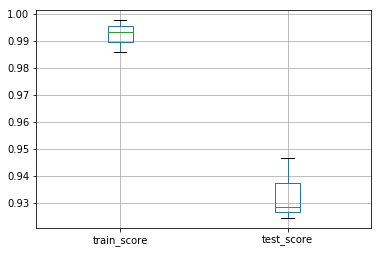

In [29]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

pipe = make_pipeline(MinMaxScaler(),
                     LogisticRegression(solver='saga', multi_class='auto', random_state=42, max_iter=5000))
param_grid = {'logisticregression__C': [0.1, 1.0, 10],
              'logisticregression__penalty': ['l2', 'l1']}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1)
scores = pd.DataFrame(cross_validate(grid, X, y, cv=3, n_jobs=-1, return_train_score=True))
scores[['train_score', 'test_score']].boxplot()

# 6. Heterogeneous data: when you work with data other than numerical

Up to now, we used `scikit-learn` to train model using numerical data.

In [30]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

`X` is a NumPy array of `float` values only. However, datasets can contains mixed types.

In [31]:
import os
data = pd.read_csv(os.path.join('data', 'titanic_openml.csv'), na_values='?')
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


The `titanic` dataset contains both categorical, text, and numeric features. We will use this dataset to predict whether a passenger survived the Titanic or not. 

Let's split the data into training and testing sets and use the `survived` column as a target.

In [32]:
y = data['survived']
X = data.drop(columns='survived')

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

One could try a `LogisticRegression` classifier and see how good it is performing.

In [34]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

/home/glemaitre/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: could not convert string to float: 'S'

Whoops, most of the classifiers are designed to work with numerical data. Therefore, we need to convert the categorical data into numeric features. The simplest way is to one-hot encode each categorical feature with the `OneHotEncoder`. Let's give an example for the `sex` and `embarked` columns. Note that we also encounter some data which are missing. We will use a `SimpleImputer` to replace the missing values with a constant values.

In [35]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
ohe = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
X_encoded = ohe.fit_transform(X_train[['sex', 'embarked']])
X_encoded.toarray()

array([[0., 1., 0., 0., 1., 0.],
       [0., 1., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.]])

This way, it is possible to encode the categorical features. However, we also want to standardize the numerical features. Thus, we need to split the original data into 2 subgroups and apply a different preprocessing: (i) one-hot encoding for the categorical data and (ii) standard scaling for the numerical data. We also need to handle missing values in both cases. For the categorical column, we replace the missing values by the string `'missing_values'` which will be interpreted as a category on its own. For the numerical data, we will replace the missing data by the mean values of the feature of interest.

In [36]:
col_cat = ['sex', 'embarked']
col_num = ['age', 'sibsp', 'parch', 'fare']

X_train_cat = X_train[col_cat]
X_train_num = X_train[col_num]
X_test_cat = X_test[col_cat]
X_test_num = X_test[col_num]

In [37]:
from sklearn.preprocessing import StandardScaler

scaler_cat = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
X_train_cat_enc = scaler_cat.fit_transform(X_train_cat)
X_test_cat_enc = scaler_cat.transform(X_test_cat)

scaler_num = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
X_train_num_scaled = scaler_num.fit_transform(X_train_num)
X_test_num_scaled = scaler_num.transform(X_test_num)

We should apply these transformations on the training and testing sets as we did in Sect. 2.1

In [38]:
import numpy as np
from scipy import sparse

X_train_scaled = sparse.hstack((X_train_cat_enc,
                                sparse.csr_matrix(X_train_num_scaled)))
X_test_scaled = sparse.hstack((X_test_cat_enc,
                               sparse.csr_matrix(X_test_num_scaled)))

Once the transformation is done, we can combine the informations which are all numerical now. Finally, we use our `LogisticRegression` classifier as a model.

In [40]:
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train_scaled, y_train)
accuracy = clf.score(X_test_scaled, y_test)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__, accuracy))

Accuracy score of the LogisticRegression is 0.79


The above pattern of first transforming the data and then fitting/scoring the classifier is exactly the one of Sect. 2.1. Therefore, we would like to use a pipeline for such purpose. However, we would also like to have different processing on different columns of our matrix. The `ColumnTransformer` transformer or the `make_column_transformer` function should be used. It is used to automatically apply different pipeline on different columns.

In [41]:
from sklearn.compose import make_column_transformer

pipe_cat = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))
pipe_num = make_pipeline(SimpleImputer(), StandardScaler())
preprocessor = make_column_transformer((col_cat, pipe_cat), (col_num, pipe_num))

pipe = make_pipeline(preprocessor, LogisticRegression(solver='lbfgs'))

pipe.fit(X_train, y_train)
accuracy = pipe.score(X_test, y_test)
print('Accuracy score of the {} is {:.2f}'.format(pipe.__class__.__name__, accuracy))

Accuracy score of the Pipeline is 0.79


Besides, it can also be used in another pipeline. Thus, we will be able to use all `scikit-learn` utilities as `cross_validate` or `GridSearchCV`.

In [42]:
pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
            transformer_weights=None,
            transformers=[('pipeline-1', Pipeline(memory=None,
        steps=[('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
          strategy='constant', verbose=0)), ('onehotencoder', OneHotEncoder(categorical_features=None, categories=None,
          dtype=<class 'numpy.float64'>, ha...r', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['age', 'sibsp', 'parch', 'fare'])])),
  ('logisticregression',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='warn',
             n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
             tol=0.0001, verbose=0, warm_start=False))],
 'columntransformer': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
          tr

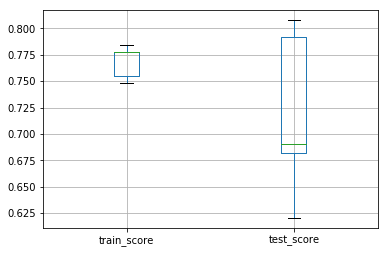

In [43]:
pipe_cat = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))
pipe_num = make_pipeline(StandardScaler(), SimpleImputer())
preprocessor = make_column_transformer((col_cat, pipe_cat), (col_num, pipe_num))

pipe = make_pipeline(preprocessor, LogisticRegression(solver='lbfgs'))

param_grid = {'columntransformer__pipeline-2__simpleimputer__strategy': ['mean', 'median'],
              'logisticregression__C': [0.1, 1.0, 10]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
scores = pd.DataFrame(cross_validate(grid, X, y, scoring='balanced_accuracy', cv=5, n_jobs=-1, return_train_score=True))
scores[['train_score', 'test_score']].boxplot()

#### Exercise

Load the adult dataset located in `./data/adult_openml.csv`. Make your own `ColumnTransformer` preprocessor. Pipeline it with a classifier. Fine tune it and check the prediction accuracy within a cross-validation.

In [ ]:
# %load solutions/05_solutions.py